# Notebook 02 – Baseline ANN (Price-Only SPY Direction Classifier)

**Goal:** Train a baseline artificial neural network (ANN) to predict whether SPY will close **up or down the next day**, using only price-based technical features.

This notebook will:

1. Load the preprocessed daily dataset from `data/processed/daily_merged.parquet`.
2. Define the feature set and the binary target `label_up`.
3. Create time-based train/validation/test splits (to avoid lookahead bias).
4. Standardize features using statistics computed on the train split only.
5. Build a windowed dataset for time-series inputs (W days → predict next day direction).
6. Define and train a simple MLP model on CPU/GPU.
7. Evaluate on validation and test sets (accuracy, confusion matrix, ROC-AUC).
8. Save the trained model weights for later comparison.


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

# Make sure we can import from src/ when running from notebooks/
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.data.dataset import make_time_splits, PriceWindowDataset
from src.models.price_only import PriceOnlyMLP

DATA_PATH = ROOT / "data" / "processed" / "daily_merged.parquet"
CHECKPOINTS_DIR = ROOT / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

ROOT, DATA_PATH


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann'),
 WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/daily_merged.parquet'))

In [2]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])

print("=== PROCESSED DATA PREVIEW ===")
display(df.head())
print("\nColumns:", df.columns.tolist())
print("Shape:", df.shape)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("\nlabel_up distribution:")
print(df["label_up"].value_counts(normalize=True))


=== PROCESSED DATA PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,vol_5,vol_20,future_price,future_ret_1d,label_up
0,2010-02-02,83.059364,83.217386,81.930636,82.216584,216327900,0.012104,0.012031,82.055548,84.347997,0.012653,0.010585,82.645493,-0.004983,0
1,2010-02-03,82.645493,83.134609,82.404697,82.683113,172730700,-0.004983,-0.004995,82.055548,84.205024,0.012873,0.010574,80.094604,-0.030865,0
2,2010-02-04,80.094604,82.043540,80.079552,82.005919,356715700,-0.030865,-0.031352,81.734995,83.931498,0.018783,0.012403,80.260124,0.002067,1
3,2010-02-05,80.260124,80.425666,78.694953,80.184871,493585800,0.002067,0.002064,81.625131,83.648186,0.018457,0.012344,79.680710,-0.007219,0
4,2010-02-08,79.680710,80.764291,79.620510,80.320322,224166900,-0.007219,-0.007245,81.148059,83.321606,0.015917,0.012270,80.681526,0.012560,1



Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20', 'future_price', 'future_ret_1d', 'label_up']
Shape: (3753, 15)
Date range: 2010-02-02 00:00:00 → 2024-12-30 00:00:00

label_up distribution:
label_up
1    0.552625
0    0.447375
Name: proportion, dtype: float64


In [3]:
# Columns we DO NOT use as input features
drop_cols = ["date", "future_price", "future_ret_1d", "label_up"]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Feature columns:")
print(feature_cols)
print("Number of features:", len(feature_cols))

# Time-based splits (same logic as script)
train_end = "2018-12-31"
val_end = "2021-12-31"

splits = make_time_splits(df, train_end=train_end, val_end=val_end)
print("\nSplit sizes:")
print("Train indices:", len(splits.train_idx))
print("Val indices:", len(splits.val_idx))
print("Test indices:", len(splits.test_idx))


Feature columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20']
Number of features: 11

Split sizes:
Train indices: 2244
Val indices: 757
Test indices: 752


In [4]:
X_all = df[feature_cols].values.astype("float32")
y_all = df["label_up"].values.astype("float32")

scaler = StandardScaler()
scaler.fit(X_all[splits.train_idx])  # fit on train only

X_scaled = scaler.transform(X_all)

df_scaled = df.copy()
df_scaled[feature_cols] = X_scaled

print("Scaled feature means (train):")
print(np.mean(X_scaled[splits.train_idx], axis=0))

print("\nScaled feature stds (train):")
print(np.std(X_scaled[splits.train_idx], axis=0))


Scaled feature means (train):
[ 4.1489507e-08  1.0088166e-07 -2.7629568e-07  1.7727335e-07
 -8.6737508e-08 -2.7358638e-09  3.0546052e-09 -1.6154877e-07
 -8.0455646e-07  4.5686271e-08  1.0582215e-07]

Scaled feature stds (train):
[0.9999994 1.        1.0000002 1.0000002 1.0000006 1.0000002 0.9999995
 1.0000006 0.9999999 0.9999994 0.9999999]


In [5]:
from src.data.dataset import PriceWindowDataset

window_size = 30
batch_size = 64

train_ds = PriceWindowDataset(df_scaled, splits.train_idx, feature_cols, window_size)
val_ds   = PriceWindowDataset(df_scaled, splits.val_idx, feature_cols, window_size)
test_ds  = PriceWindowDataset(df_scaled, splits.test_idx, feature_cols, window_size)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Window size: {window_size}")
print(f"Train samples: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# peek at one batch
X_batch, y_batch = next(iter(train_loader))
print("X_batch shape:", X_batch.shape)  # (batch, W, F)
print("y_batch shape:", y_batch.shape)


Window size: 30
Train samples: 2215, Val: 728, Test: 723
X_batch shape: torch.Size([64, 30, 11])
y_batch shape: torch.Size([64])


In [6]:
from src.models.price_only import PriceOnlyMLP

num_features = len(feature_cols)
model = PriceOnlyMLP(window_size=window_size, num_features=num_features)
print(model)


PriceOnlyMLP(
  (net): Sequential(
    (0): Linear(in_features=330, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [7]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.BCEWithLogitsLoss()

    total_loss, total_correct, total_count = 0.0, 0, 0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == y).sum().item()
        total_count += y.size(0)

    return total_loss / total_count, total_correct / total_count


@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    total_loss, total_correct, total_count = 0.0, 0, 0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == y).sum().item()
        total_count += y.size(0)

    return total_loss / total_count, total_correct / total_count


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_features = len(feature_cols)

model = PriceOnlyMLP(window_size=window_size, num_features=num_features)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Using device: {device}")

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
    )


Using device: cpu
Epoch 01 | train_loss=0.6928 acc=0.5409 | val_loss=0.6869 acc=0.5646
Epoch 02 | train_loss=0.6867 acc=0.5585 | val_loss=0.6890 acc=0.5426
Epoch 03 | train_loss=0.6844 acc=0.5598 | val_loss=0.6946 acc=0.5069
Epoch 04 | train_loss=0.6812 acc=0.5684 | val_loss=0.6971 acc=0.5467
Epoch 05 | train_loss=0.6757 acc=0.5806 | val_loss=0.8917 acc=0.4327
Epoch 06 | train_loss=0.6712 acc=0.5765 | val_loss=0.7142 acc=0.5288
Epoch 07 | train_loss=0.6668 acc=0.5878 | val_loss=0.7565 acc=0.4451
Epoch 08 | train_loss=0.6630 acc=0.5950 | val_loss=0.7316 acc=0.5124
Epoch 09 | train_loss=0.6544 acc=0.6122 | val_loss=0.7718 acc=0.4588
Epoch 10 | train_loss=0.6585 acc=0.5955 | val_loss=0.7874 acc=0.4327
Epoch 11 | train_loss=0.6454 acc=0.6194 | val_loss=0.8017 acc=0.4533
Epoch 12 | train_loss=0.6329 acc=0.6230 | val_loss=0.7507 acc=0.5234
Epoch 13 | train_loss=0.6271 acc=0.6470 | val_loss=0.9168 acc=0.4341
Epoch 14 | train_loss=0.6179 acc=0.6501 | val_loss=0.8776 acc=0.4505
Epoch 15 | train

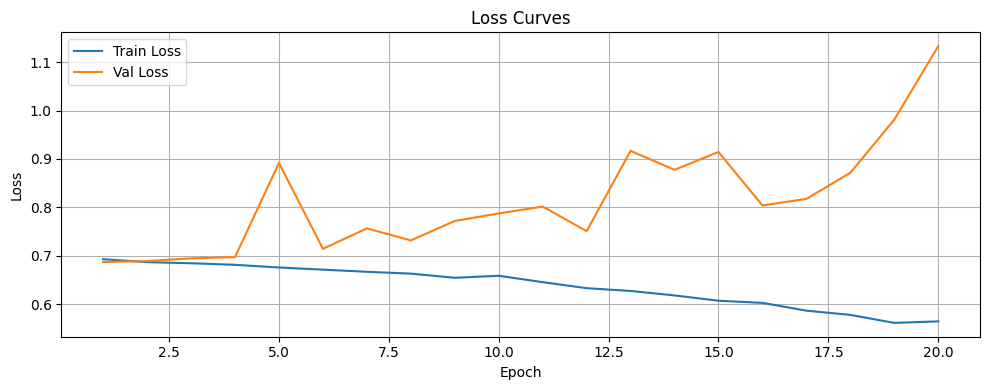

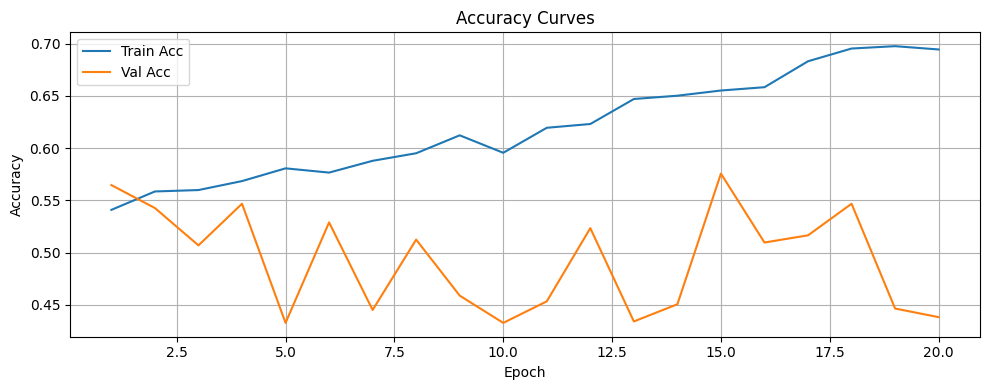

In [9]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_logits = []
    all_y = []

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        all_logits.append(logits.cpu().numpy())
        all_y.append(y.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y)

    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    preds = (probs > 0.5).astype("int64")

    return all_y, preds, probs

test_y, test_preds, test_probs = get_predictions(model, test_loader, device)

test_acc = accuracy_score(test_y, test_preds)
try:
    test_auc = roc_auc_score(test_y, test_probs)
except ValueError:
    test_auc = np.nan

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ROC-AUC:  {test_auc:.4f}")


Test Accuracy: 0.4689
Test ROC-AUC:  0.4983


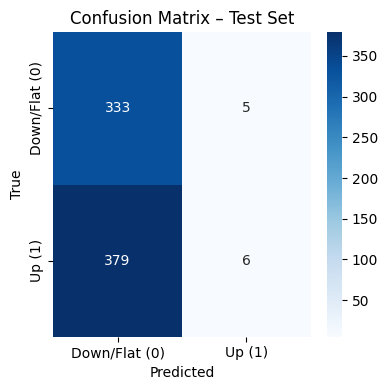

(array([[333,   5],
        [379,   6]]),
 0.46887966804979253)

In [11]:
cm = confusion_matrix(test_y, test_preds)
labels = ["Down/Flat (0)", "Up (1)"]

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

cm, test_acc


In [12]:
model_path = CHECKPOINTS_DIR / "price_only_mlp.pt"
torch.save(model.state_dict(), model_path)
model_path


WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/checkpoints/price_only_mlp.pt')

## Notes for Report – Baseline Price-Only ANN

- **Input features:** technical indicators derived from daily SPY prices:
  - 1-day returns, log returns
  - 5-day and 20-day moving averages
  - 5-day and 20-day rolling volatility
- **Target:** `label_up = 1` if next day's close > today's close, else `0`.
- **Data splits:** time-based (no shuffling)
  - Train: up to 2018-12-31
  - Validation: 2019-01-01 to 2021-12-31
  - Test: 2022-01-01 onwards
- **Preprocessing:**
  - Features standardized using mean and std computed from the **train split only**.
  - Data is fed to the model as sliding windows of `W = 30` days.
- **Model:** MLP (fully connected ANN)
  - Input: flattened window (30 days × F features)
  - Hidden layers: [64, 32] units with ReLU activations
  - Output: single logit (binary classification with BCEWithLogitsLoss)
- **Results:**
  - Report test accuracy and ROC-AUC from the previous cells.
  - Compare to a naive baseline that always predicts the majority class (≈ 55% "up" days).
- **Limitations:**
  - SPY daily direction is extremely noisy and close to efficient.
  - Purely price-based models struggle to achieve consistent out-of-sample edge.
  - This baseline serves as a reference point for later models that incorporate macroeconomic and news sentiment data.
